### Preprocessing

In [1]:
import pickle

with open('undersampled_data.pkl', 'rb') as lf:
    labels = pickle.load(lf)

with open('undersampled_posts.pkl', 'rb') as pf:
    posts = pickle.load(pf)

In [2]:
# Tokenizing data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 50
max_features = 10000
max_words = 10000

Using TensorFlow backend.


In [3]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(posts)
sequences = tokenizer.texts_to_sequences(posts)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 29926 unique tokens


In [4]:
data = pad_sequences(sequences, maxlen=max_len)

In [5]:
labels = np.asarray(labels)

In [6]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (28800, 50)
Shape of label tensor: (28800,)


In [7]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [8]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

one_hot_types = []

for label in labels:
    bin_type = []
    
    if (label[0] == 'I'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (label[1] == 'N'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (label[2] == 'T'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (label[3] == 'J'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    one_hot_types.append(bin_type)

In [9]:
y = np.asarray(one_hot_types).astype('float32')

x_test = data[:4000]
y_test = y[:4000]

x_train = data[4000:]
y_train = y[4000:]


In [11]:
import os

embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
embedding_dim = 50
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
from keras import models
from keras import layers
from keras.layers import Embedding, Flatten, Dense, LSTM, regularizers

def build_model():
    model = models.Sequential()
    model.add(Embedding(max_features, max_len))
    model.add(LSTM(32))
    model.add(Dense(4, activation='sigmoid'))

    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [17]:
model = build_model()
history = model.fit(x_train, y_train, epochs = 40, batch_size = 128, validation_split=0.2)


Train on 19840 samples, validate on 4960 samples
Epoch 1/40
19840/19840 [==============================] - 9s 441us/step - loss: 0.7056 - acc: 0.5134 - val_loss: 0.6972 - val_acc: 0.5204
Epoch 2/40
19840/19840 [==============================] - 8s 382us/step - loss: 0.6927 - acc: 0.5279 - val_loss: 0.6918 - val_acc: 0.5273
Epoch 3/40
19840/19840 [==============================] - 8s 396us/step - loss: 0.6898 - acc: 0.5366 - val_loss: 0.6901 - val_acc: 0.5327
Epoch 4/40
19840/19840 [==============================] - 7s 371us/step - loss: 0.6876 - acc: 0.5448 - val_loss: 0.6896 - val_acc: 0.5352
Epoch 5/40
19840/19840 [==============================] - 7s 372us/step - loss: 0.6859 - acc: 0.5506 - val_loss: 0.6872 - val_acc: 0.5460
Epoch 6/40
19840/19840 [==============================] - 7s 372us/step - loss: 0.6844 - acc: 0.5552 - val_loss: 0.6872 - val_acc: 0.5447
Epoch 7/40
19840/19840 [==============================] - 7s 373us/step - loss: 0.6832 - acc: 0.5593 - val_loss: 0.6865 - v

In [ ]:
model = build_model()
y_pred = model.predict(x_test)
history = model.fit(x_train, y_train, epochs = 40, batch_size = 128)
results = model.evaluate(x_test, y_test)
results

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "LSTM"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=type_labels)
matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(15,10))
plot_confusion_matrix(matrix, classes=type_labels, normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
                      title='I-E Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
                      title='N-S Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
                      title='T-F Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
                      title='J-P Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
plt.savefig(name)
plt.show()
pictures.append(name)

Normalized confusion matrix


<Figure size 1500x1000 with 2 Axes>

Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 2 Axes>

Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 2 Axes>

Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 2 Axes>

Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 2 Axes>

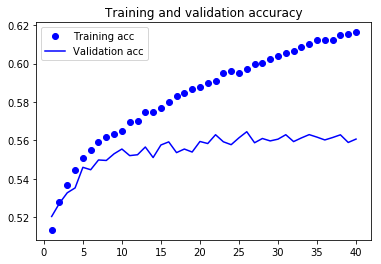

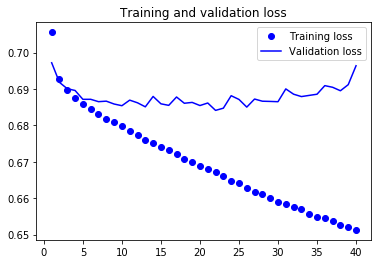

In [18]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
def myprint(s):
    with open('results.log','a+') as f:
        print(s, file=f)
    f.close()
        
log_file = open('results.log', 'a+')

log_file.write("\n=================================================================")
log_file.write( "\n" + str(now.month) + "/" + str(now.day) + "/" + str(now.year) + " " + \
str(now.hour) + ":" + str(now.minute) + ":" + str(now.second) + "\n")

log_file.close()

model.summary(print_fn=myprint)

log_file = open('results.log', 'a+')

log_file.write("Results:\t" + str(results) + "\n")

log_file.write("Images:\n")
log_file.write("\t" + pictures[0] + "\n")
log_file.write("\t" + pictures[1] + "\n")
log_file.write("\t" + pictures[2] + "\n")
log_file.write("\t" + pictures[3] + "\n")
log_file.write("\t" + pictures[4] + "\n")

log_file.close()